In [1]:
# Installing necessary libraries in Colab
!pip install opendatasets transformers easyocr opencv-python-headless -q Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [2]:
from google.colab import files
uploaded = files.upload()


Saving archive.zip to archive.zip


In [3]:
!unzip /content/archive.zip -d /content/

Archive:  /content/archive.zip
  inflating: /content/data/1.jpg     
  inflating: /content/data/10.jpg    
  inflating: /content/data/100.jpg   
  inflating: /content/data/101.jpg   
  inflating: /content/data/102.jpg   
  inflating: /content/data/103.jpg   
  inflating: /content/data/104.jpg   
  inflating: /content/data/105.jpg   
  inflating: /content/data/106.jpg   
  inflating: /content/data/107.jpg   
  inflating: /content/data/108.jpg   
  inflating: /content/data/109.jpg   
  inflating: /content/data/11.jpg    
  inflating: /content/data/110.jpg   
  inflating: /content/data/111.jpg   
  inflating: /content/data/112.jpg   
  inflating: /content/data/113.jpg   
  inflating: /content/data/114.jpg   
  inflating: /content/data/115.jpg   
  inflating: /content/data/116.jpg   
  inflating: /content/data/117.jpg   
  inflating: /content/data/118.jpg   
  inflating: /content/data/119.jpg   
  inflating: /content/data/12.jpg    
  inflating: /content/data/120.jpg   
  inflating: /conte

In [4]:
import os

data_dir = "/content/data"

# List of all image files with supported extensions
image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Print the number of image files
print(f"Total images found: {len(image_files)}")


Total images found: 129


In [5]:
#import statement
import os
import cv2
import easyocr
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import pandas as pd


In [6]:
def preprocess_image(image_path):
    try:
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None or os.path.getsize(image_path) == 0:
            print(f"Error reading image: {image_path}")
            return None
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 11, 2)
        return Image.fromarray(thresh)
    except Exception as e:
        print(f"Exception processing {image_path}: {e}")
        return None

# Init EasyOCR
easyocr_reader = easyocr.Reader(['en'])

# Init BLIP-2 (multimodal LLM) from Hugging Face
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Path to dataset (update with your path)
dataset_path = './data'

# Store results
results = []

# Function to process each image
def process_image(image_path):
    # Apply EasyOCR for text extraction
    try:
        easyocr_results = easyocr_reader.readtext(image_path) # This line is where the AttributeError originated
        easyocr_text = ' '.join([result[1] for result in easyocr_results])
    except AttributeError as e: # Catch the AttributeError
        print(f"Skipping image {image_path} due to error: {e}") # Print the error to diagnose
        return None, None # Return None to skip this image for the comparison

    # Open image and prepare it for BLIP-2
    image = Image.open(image_path).convert("RGB")

    # Prepare inputs for BLIP-2
    inputs = processor(images=image, text=easyocr_text, return_tensors="pt")

    # Generate caption from BLIP-2
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)

    return easyocr_text, caption

# Process each image in the dataset folder
for image_filename in os.listdir(dataset_path):
    if image_filename.endswith('.jpg') or image_filename.endswith('.png'):
        image_path = os.path.join(dataset_path, image_filename)

        # Process the image
        result = process_image(image_path)
        if result: # Only append to results if the process_image call was successful
            easyocr_text, blip2_caption = result
            results.append({
                'image': image_filename,
                'easyocr_text': easyocr_text,
                'blip2_caption': blip2_caption
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('ocr_blip2_comparison_results.csv', index=False)

# Display the first few results
print(results_df.head())

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Skipping image ./data/129.jpg due to error: 'NoneType' object has no attribute 'shape'
Skipping image ./data/26.jpg due to error: 'NoneType' object has no attribute 'shape'
Skipping image ./data/77.jpg due to error: 'NoneType' object has no attribute 'shape'
Skipping image ./data/41.jpg due to error: 'NoneType' object has no attribute 'shape'
Skipping image ./data/90.jpg due to error: 'NoneType' object has no attribute 'shape'
Skipping image ./data/1.jpg due to error: 'NoneType' object has no attribute 'shape'
Skipping image ./data/70.jpg due to error: 'NoneType' object has no attribute 'shape'
     image                                       easyocr_text  \
0   76.jpg                                MletLxo_ 1om M luul   
1   15.jpg  Doctors Urgent Care Walk-In Clinic 4900 33rd A...   
2  110.jpg  Kael Leep M67 hs LIIL Ren 2 Rap Deu "3 nywc{ @...   
3  128.jpg  DR. BABA SAHEBAMBEDKAR HOSPITAL, ROHINI Govt o...   
4  115.jpg  M Manipal Hospital Manipal i*spiaeo oy LIFC Dr...   

       

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_score(text1, text2):
    if not text1 or not text2:
        return 0.0  # Return 0 similarity if any text is None or empty
    try:
        count_vectorizer = CountVectorizer().fit_transform([text1, text2])
        similarity_matrix = cosine_similarity(count_vectorizer)
        return similarity_matrix[0][1]
    except Exception as e:
        print(f"Error computing cosine similarity: {e}")
        return 0.0

cosine_similarities = []
for index, row in results_df.iterrows():
    easyocr_text = row.get('easyocr_text', None)
    blip2_caption = row.get('blip2_caption', None)

    similarity = cosine_similarity_score(easyocr_text, blip2_caption)
    cosine_similarities.append(similarity)

results_df['cosine_similarity'] = cosine_similarities

print(results_df.head())

     image                                       easyocr_text  \
0   76.jpg                                MletLxo_ 1om M luul   
1   15.jpg  Doctors Urgent Care Walk-In Clinic 4900 33rd A...   
2  110.jpg  Kael Leep M67 hs LIIL Ren 2 Rap Deu "3 nywc{ @...   
3  128.jpg  DR. BABA SAHEBAMBEDKAR HOSPITAL, ROHINI Govt o...   
4  115.jpg  M Manipal Hospital Manipal i*spiaeo oy LIFC Dr...   

                                       blip2_caption  cosine_similarity  
0  mletlxo _ 1om m luul _ _ _ _ _ _ _ _ _ _ _ _ _...           0.666667  
1  doctors urgent care walk - in clinic 4900 33rd...           1.000000  
2  kael leep m67 hs liil ren 2 rap deu " 3 nywc {...           1.000000  
3  dr. baba sahebambedkar hospital, rohini govt o...           0.993231  
4  m manipal hospital manipal i * spiaeo oy lifc ...           1.000000  


In [10]:
from fuzzywuzzy import fuzz

def fuzzy_match_score(text1, text2):
    return fuzz.ratio(text1, text2)

# Compute fuzzy match scores for each image
fuzzy_scores = []
for index, row in results_df.iterrows():
    easyocr_text = row['easyocr_text']
    blip2_caption = row['blip2_caption']

    fuzzy_score = fuzzy_match_score(easyocr_text, blip2_caption)
    fuzzy_scores.append(fuzzy_score)

# Add fuzzy match scores to the DataFrame
results_df['fuzzy_match_score'] = fuzzy_scores

print(results_df.head())

     image                                       easyocr_text  \
0   76.jpg                                MletLxo_ 1om M luul   
1   15.jpg  Doctors Urgent Care Walk-In Clinic 4900 33rd A...   
2  110.jpg  Kael Leep M67 hs LIIL Ren 2 Rap Deu "3 nywc{ @...   
3  128.jpg  DR. BABA SAHEBAMBEDKAR HOSPITAL, ROHINI Govt o...   
4  115.jpg  M Manipal Hospital Manipal i*spiaeo oy LIFC Dr...   

                                       blip2_caption  cosine_similarity  \
0  mletlxo _ 1om m luul _ _ _ _ _ _ _ _ _ _ _ _ _...           0.666667   
1  doctors urgent care walk - in clinic 4900 33rd...           1.000000   
2  kael leep m67 hs liil ren 2 rap deu " 3 nywc {...           1.000000   
3  dr. baba sahebambedkar hospital, rohini govt o...           0.993231   
4  m manipal hospital manipal i * spiaeo oy lifc ...           1.000000   

   fuzzy_match_score  
0                 44  
1                 85  
2                 83  
3                 71  
4                 80  


In [11]:
from nltk.translate.bleu_score import sentence_bleu

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def bleu_score(reference, hypothesis):
    if not reference or not hypothesis:
        return 0.0
    try:
        reference_tokens = reference.split()
        hypothesis_tokens = hypothesis.split()
        smoothie = SmoothingFunction().method4
        return sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smoothie)
    except Exception as e:
        print(f"BLEU score error: {e}")
        return 0.0

bleu_scores = []
for index, row in results_df.iterrows():
    easyocr_text = row.get('easyocr_text', None)
    blip2_caption = row.get('blip2_caption', None)

    bleu_score_value = bleu_score(easyocr_text, blip2_caption)
    bleu_scores.append(bleu_score_value)

results_df['bleu_score'] = bleu_scores

print(results_df.head())


     image                                       easyocr_text  \
0   76.jpg                                MletLxo_ 1om M luul   
1   15.jpg  Doctors Urgent Care Walk-In Clinic 4900 33rd A...   
2  110.jpg  Kael Leep M67 hs LIIL Ren 2 Rap Deu "3 nywc{ @...   
3  128.jpg  DR. BABA SAHEBAMBEDKAR HOSPITAL, ROHINI Govt o...   
4  115.jpg  M Manipal Hospital Manipal i*spiaeo oy LIFC Dr...   

                                       blip2_caption  cosine_similarity  \
0  mletlxo _ 1om m luul _ _ _ _ _ _ _ _ _ _ _ _ _...           0.666667   
1  doctors urgent care walk - in clinic 4900 33rd...           1.000000   
2  kael leep m67 hs liil ren 2 rap deu " 3 nywc {...           1.000000   
3  dr. baba sahebambedkar hospital, rohini govt o...           0.993231   
4  m manipal hospital manipal i * spiaeo oy lifc ...           1.000000   

   fuzzy_match_score  bleu_score  
0                 44    0.014320  
1                 85    0.036140  
2                 83    0.072091  
3                 

In [12]:
import Levenshtein

def levenshtein_ratio(s1, s2):
    if s1 and s2:
        return Levenshtein.ratio(s1, s2)  # Returns a float between 0 and 1
    return 0.0

results_df['levenshtein_ratio'] = results_df.apply(
    lambda row: levenshtein_ratio(str(row['easyocr_text']), str(row['blip2_caption'])),
    axis=1
)

print(results_df.head())



     image                                       easyocr_text  \
0   76.jpg                                MletLxo_ 1om M luul   
1   15.jpg  Doctors Urgent Care Walk-In Clinic 4900 33rd A...   
2  110.jpg  Kael Leep M67 hs LIIL Ren 2 Rap Deu "3 nywc{ @...   
3  128.jpg  DR. BABA SAHEBAMBEDKAR HOSPITAL, ROHINI Govt o...   
4  115.jpg  M Manipal Hospital Manipal i*spiaeo oy LIFC Dr...   

                                       blip2_caption  cosine_similarity  \
0  mletlxo _ 1om m luul _ _ _ _ _ _ _ _ _ _ _ _ _...           0.666667   
1  doctors urgent care walk - in clinic 4900 33rd...           1.000000   
2  kael leep m67 hs liil ren 2 rap deu " 3 nywc {...           1.000000   
3  dr. baba sahebambedkar hospital, rohini govt o...           0.993231   
4  m manipal hospital manipal i * spiaeo oy lifc ...           1.000000   

   fuzzy_match_score  bleu_score  levenshtein_ratio  
0                 44    0.014320           0.438356  
1                 85    0.036140           0.84700

In [23]:
def jaccard_similarity(s1, s2):
    if s1 and s2:
        set1 = set(s1.lower().split())
        set2 = set(s2.lower().split())
        intersection = set1.intersection(set2)
        union = set1.union(set2)
        return len(intersection) / len(union) if union else 0.0
    return 0.0

results_df['jaccard_similarity'] = results_df.apply(
    lambda row: jaccard_similarity(str(row['easyocr_text']), str(row['blip2_caption'])),
    axis=1
)

print(results_df.head())



     image                                       easyocr_text  \
0   76.jpg                                MletLxo_ 1om M luul   
1   15.jpg  Doctors Urgent Care Walk-In Clinic 4900 33rd A...   
2  110.jpg  Kael Leep M67 hs LIIL Ren 2 Rap Deu "3 nywc{ @...   
3  128.jpg  DR. BABA SAHEBAMBEDKAR HOSPITAL, ROHINI Govt o...   
4  115.jpg  M Manipal Hospital Manipal i*spiaeo oy LIFC Dr...   

                                       blip2_caption  cosine_similarity  \
0  mletlxo _ 1om m luul _ _ _ _ _ _ _ _ _ _ _ _ _...           0.666667   
1  doctors urgent care walk - in clinic 4900 33rd...           1.000000   
2  kael leep m67 hs liil ren 2 rap deu " 3 nywc {...           1.000000   
3  dr. baba sahebambedkar hospital, rohini govt o...           0.993231   
4  m manipal hospital manipal i * spiaeo oy lifc ...           1.000000   

   fuzzy_match_score  bleu_score  levenshtein_ratio  jaccard_similarity  \
0                 44    0.014320           0.438356            0.500000   
1       

In [14]:
#calculation average of each matrix

print("Average Fuzzy:", results_df["fuzzy_match_score"].mean())
print("Average Cosine:", results_df["cosine_similarity"].mean())
print("Average BLEU:", results_df["bleu_score"].mean())
print("Average Levenshtein Ratio:", results_df["levenshtein_ratio"].mean())
print("Average Jaccard Similarity:", results_df["jaccard_similarity"].mean())


Average Fuzzy: 72.57364341085271
Average Cosine: 0.9159739633096733
Average BLEU: 0.04894522566942637
Average Levenshtein Ratio: 0.7799242695112767
Average Jaccard Similarity: 0.5442903426524941


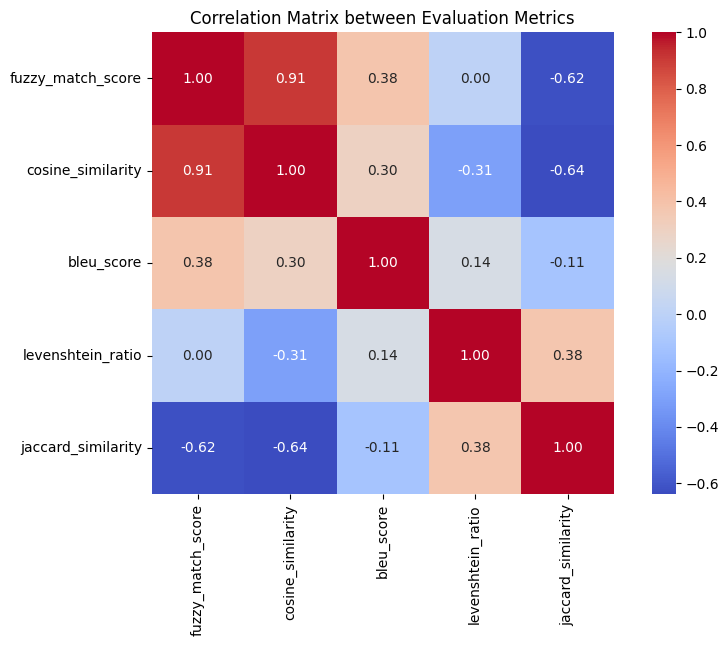

In [15]:
#correlation matrix heatmap

import seaborn as sns
import matplotlib.pyplot as plt

# Select only the numeric metric columns
metric_columns = ['fuzzy_match_score', 'cosine_similarity', 'bleu_score',
                  'levenshtein_ratio', 'jaccard_similarity']

# Compute correlation matrix
correlation_matrix = results_df[metric_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix between Evaluation Metrics')
plt.show()


In [16]:
#detection of outlier

thresholds = {
    'fuzzy_match_score': 50,
    'cosine_similarity': 0.5,
    'bleu_score': 0.02,
    'levenshtein_ratio': 0.5,
    'jaccard_similarity': 0.3
}

# Flag images below threshold on all or most metrics
def is_outlier(row):
    return (
        row['fuzzy_match_score'] < thresholds['fuzzy_match_score'] and
        row['cosine_similarity'] < thresholds['cosine_similarity'] and
        row['bleu_score'] < thresholds['bleu_score'] and
        row['levenshtein_ratio'] < thresholds['levenshtein_ratio'] and
        row['jaccard_similarity'] < thresholds['jaccard_similarity']
    )

# Apply outlier detection
results_df['is_outlier'] = results_df.apply(is_outlier, axis=1)

# Filter outliers
outliers_df = results_df[results_df['is_outlier'] == True]

# Display or export
print("Outlier Images Detected:", len(outliers_df))
display(outliers_df[['image', 'easyocr_text', 'blip2_caption'] + metric_columns])

# Optionally save to CSV
outliers_df.to_csv('ocr_blip2_outliers.csv', index=False)


Outlier Images Detected: 0


,image,easyocr_text,blip2_caption,fuzzy_match_score,cosine_similarity,bleu_score,levenshtein_ratio,jaccard_similarity


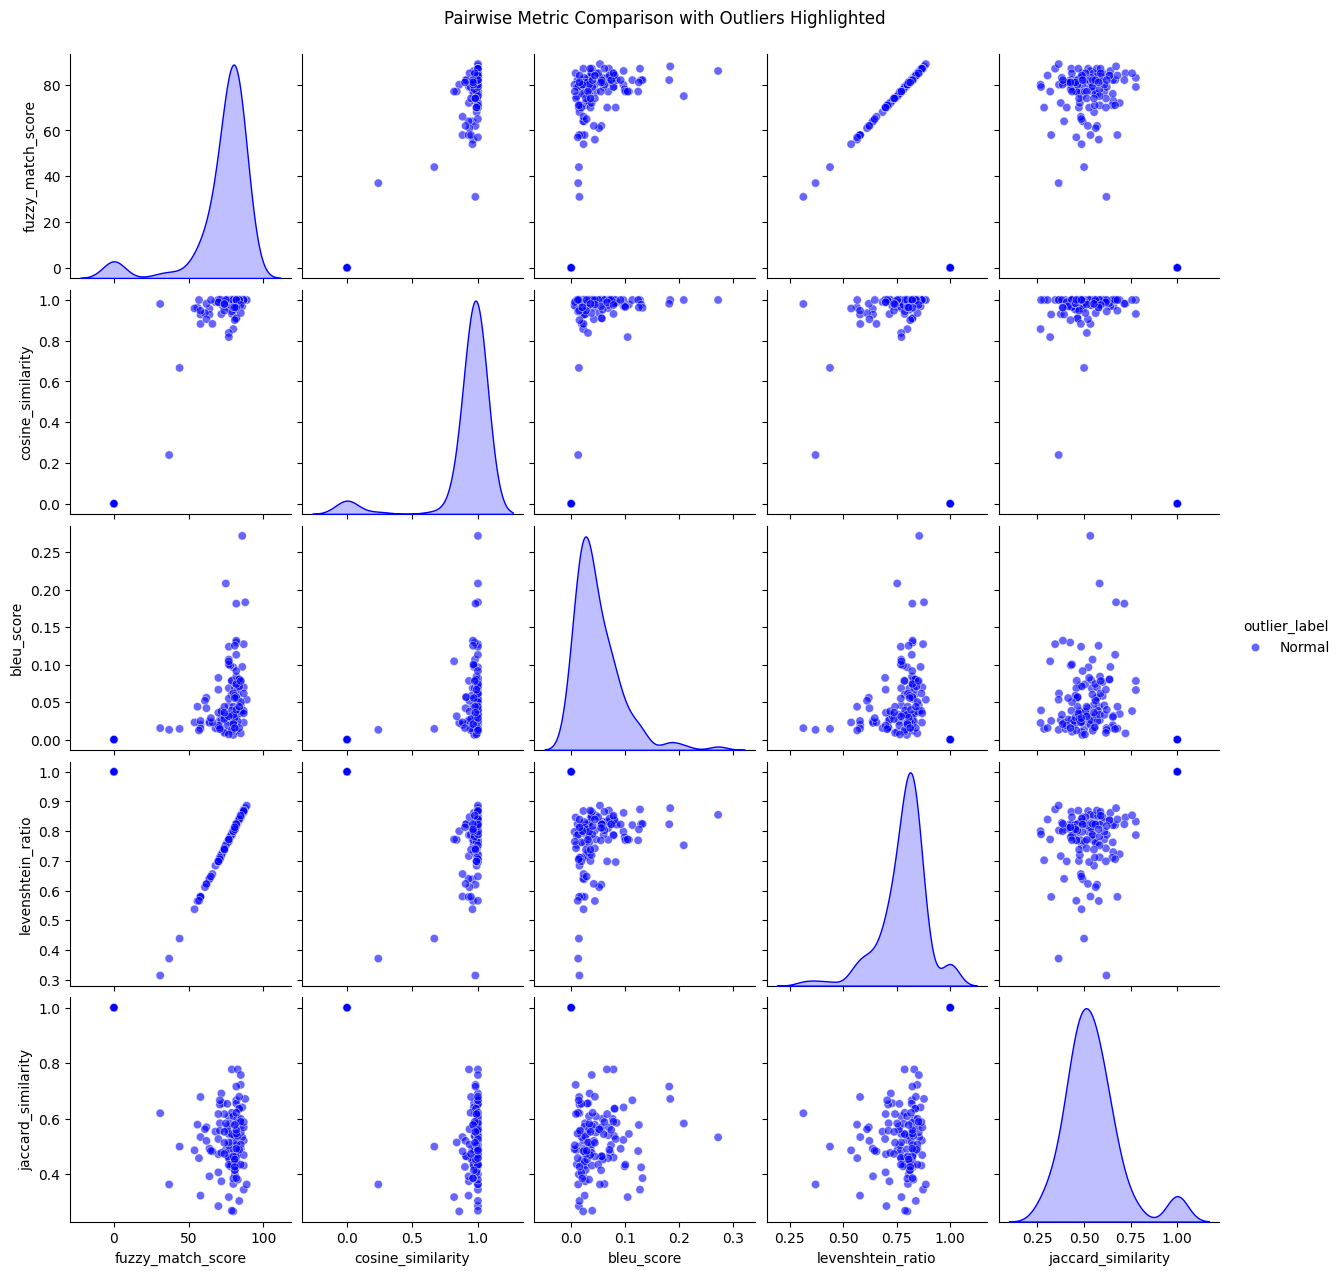

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add a column to color the outliers
results_df['outlier_label'] = results_df['is_outlier'].map({True: 'Outlier', False: 'Normal'})

# Pairplot for visualizing the metric distributions and outliers
sns.pairplot(results_df, vars=[
    'fuzzy_match_score', 'cosine_similarity', 'bleu_score',
    'levenshtein_ratio', 'jaccard_similarity'
], hue='outlier_label', palette={'Outlier': 'red', 'Normal': 'blue'}, plot_kws={'alpha': 0.6})

plt.suptitle("Pairwise Metric Comparison with Outliers Highlighted", y=1.02)
plt.show()


<ipython-input-18-4aa35e943784>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='outlier_score', data=results_df, palette='magma')


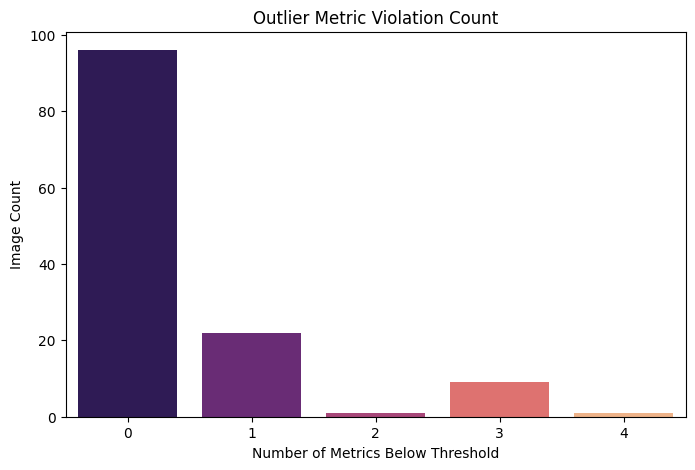

In [18]:
def outlier_score(row):
    return sum([
        row['fuzzy_match_score'] < thresholds['fuzzy_match_score'],
        row['cosine_similarity'] < thresholds['cosine_similarity'],
        row['bleu_score'] < thresholds['bleu_score'],
        row['levenshtein_ratio'] < thresholds['levenshtein_ratio'],
        row['jaccard_similarity'] < thresholds['jaccard_similarity']
    ])

results_df['outlier_score'] = results_df.apply(outlier_score, axis=1)

# Histogram of outlier score
plt.figure(figsize=(8, 5))
sns.countplot(x='outlier_score', data=results_df, palette='magma')
plt.title("Outlier Metric Violation Count")
plt.xlabel("Number of Metrics Below Threshold")
plt.ylabel("Image Count")
plt.show()


In [19]:
# Count how many times each metric fell below its threshold
violation_counts = {
    'Fuzzy Match Score': (results_df['fuzzy_match_score'] < thresholds['fuzzy_match_score']).sum(),
    'Cosine Similarity': (results_df['cosine_similarity'] < thresholds['cosine_similarity']).sum(),
    'BLEU Score': (results_df['bleu_score'] < thresholds['bleu_score']).sum(),
    'Levenshtein Ratio': (results_df['levenshtein_ratio'] < thresholds['levenshtein_ratio']).sum(),
    'Jaccard Similarity': (results_df['jaccard_similarity'] < thresholds['jaccard_similarity']).sum(),
}

# Convert to DataFrame for visualization
violation_df = pd.DataFrame.from_dict(violation_counts, orient='index', columns=['Violation Count']).reset_index()
violation_df.columns = ['Metric', 'Violation Count']

print(violation_df)


               Metric  Violation Count
0   Fuzzy Match Score               10
1   Cosine Similarity                8
2          BLEU Score               31
3   Levenshtein Ratio                3
4  Jaccard Similarity                3
